In [7]:
import json, nltk, boto3, time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from nltk import word_tokenize
tokenizer = nltk.RegexpTokenizer(r"\w+")

## SentimentIntensityAnalyzer & MultiProcessing

In [8]:
## load data
data = json.load(open('expert_tweets_2.json'))
name, text, original, time = [], [], [], []
for key in data:
    for pair in data[key]:
        if len(pair[0].split(' '))< 5: continue
        name.append(key)
        text.append(pair[0])
        original.append('[Original]' in pair[0])
        time.append(pair[1])
        
data_df = pd.DataFrame({'name': name, 'text':text,
                        'is_original': original, 'time': time})
data_df['text'] = data_df['text'].apply(lambda x: x[x.index(']')+1:])
#data_df.to_csv('expert_tweets.csv', index=False)

In [10]:
from multiprocessing import Pool
import time
sid = SentimentIntensityAnalyzer()
texts = list(data_df['text'])
all_results = []
with Pool(2) as p:
    t0 = time.time()
    result = p.map(sid.polarity_scores, texts)
    print(len(result), time.time()-t0)

268658 50.22187280654907


In [19]:
data_df['neg'] = [i['neg'] for i in result]
data_df['neu'] = [i['neu'] for i in result]
data_df['pos'] = [i['pos'] for i in result]
data_df['compound'] = [i['compound'] for i in result]

In [51]:
data_df.to_csv('expert_tweets.csv', index=False)

## Brief Analysis

In [116]:
data_df = pd.read_csv('expert_tweets.csv')
data_df.head()

,name,text,is_original,time,neg,neu,pos,compound
0,BrettDSchaefer,Member States of the @ITU should remind Zhao t...,False,May 11,0.000,1.000,0.000,0.0000
1,BrettDSchaefer,Economic freedom and the empowerment of women ...,False,Feb 26,0.000,0.744,0.256,0.9136
2,BrettDSchaefer,"Next week, the World Intellectual Property Org...",True,Feb 24,0.115,0.688,0.197,0.6486
3,BrettDSchaefer,The @UN hit a new low today publishing its Ant...,False,Feb 12,0.115,0.717,0.167,0.5267
4,BrettDSchaefer,The short-term memory on this is puzzling. Chi...,True,Jan 22,0.000,0.848,0.152,0.7003


In [160]:
sent = 'They’d rather arrest hundreds of American citizens then 3 of their own. Very telling'
sid.polarity_scores(sent)

{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.34}

In [102]:
from datetime import datetime
import numpy as np

In [103]:
def change_time(x):
    if isinstance(x, float): return np.NAN
    if len(x.split(' '))==2: return 2020
    elif len(x.split(' ')) == 1: return 2020
    return int('20'+x.split(' ')[-1])
data_df['time'] = data_df['time'].apply(change_time)

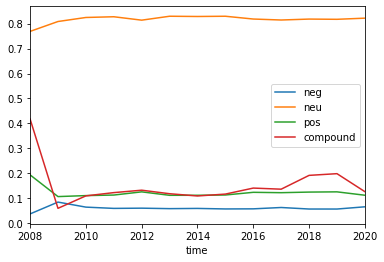

In [109]:
import seaborn as sns
m = data_df.groupby('time').mean()
m.plot()

In [21]:
data_df.groupby('is_original').mean()

,neg,neu,pos,compound
is_original,,,,
False,0.063533,0.83203,0.104436,0.122336
True,0.062975,0.81240,0.124606,0.153990


## Save Data
Because of the discussion that the values of negative/ positive/ neutral scores are relatively hard to compare, I took the binary value with 0.6 threshold instead, and take the average for each expert.

In [167]:
data_df['is_neg'] = data_df['neg'].apply(lambda x: 1 if x>0.6 else 0)
data_df['is_pos'] = data_df['pos'].apply(lambda x: 1 if x>0.6 else 0)
data_df['is_neu'] = data_df['neu'].apply(lambda x: 1 if x>0.6 else 0)

In [168]:
data_df = data_df.groupby('name').mean()
data_df = data_df.reset_index()
data_df.to_csv('avg_sentiment.csv', index=False)